<a href="https://colab.research.google.com/github/beamscource/colab_notebooks/blob/main/pytorch_lt_hf_transformers_nlp_asr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Basic End-to-End Flow

### Introduction

PyTorch is a Python library which offers an **eager approach to differentiation** instead of defining static graphs, allowing for greater flexibility in the way networks are created, trained, and operated.

Similar to DyNet and Chainer, and in contrast to static frameworks like TensorFlow/Theano/Caffe, models are not compiled before execution.

PyTorch has two lineages. First, it derives many features and concepts from Torch, which was a Lua-based neural network library that dates back to 2002. Its other major parent is Chainer, created in Japan in 2015.

The library also comes with modules that help with manipulating text, images, and audio (*torchtext*, *torchvision*, and *torchaudio*), along with built-in variants of popular architectures such as ResNet (with weights that can be downloaded to provide assistance with *transfer learning*).

In 2022, about 85% of pre-trained models on HuggingFace are PyTorch models (https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2022/). Despite the fact that PyTorch is used by companies like Twitter, Salesforce, Tesla, Uber, and NVIDIA, the consensus seems to be that TF still offers better native deployment capabilities and that tf.keras might be better suited for a complete beginner.

### Get the data

Image data:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp drive/MyDrive/_NN_NLP/PyTorch/datasets/shoes.zip .

In [7]:
!unzip shoes.zip

Archive:  shoes.zip
   creating: test/
   creating: test/boot/
  inflating: test/boot/boot (5000).jpg  
  inflating: test/boot/boot (948).jpg  
  inflating: test/boot/boot (949).jpg  
  inflating: test/boot/boot (950).jpg  
  inflating: test/boot/boot (951).jpg  
  inflating: test/boot/boot (952).jpg  
  inflating: test/boot/boot (953).jpg  
  inflating: test/boot/boot (954).jpg  
  inflating: test/boot/boot (955).jpg  
  inflating: test/boot/boot (956).jpg  
  inflating: test/boot/boot (957).jpg  
  inflating: test/boot/boot (958).jpg  
  inflating: test/boot/boot (959).jpg  
  inflating: test/boot/boot (960).jpg  
  inflating: test/boot/boot (961).jpg  
  inflating: test/boot/boot (962).jpg  
  inflating: test/boot/boot (963).jpg  
  inflating: test/boot/boot (964).jpg  
  inflating: test/boot/boot (965).jpg  
  inflating: test/boot/boot (966).jpg  
  inflating: test/boot/boot (967).jpg  
  inflating: test/boot/boot (968).jpg  
  inflating: test/boot/boot (969).jpg  
  inflating: tes

Audio data:

In [ ]:
# downloading and unzipping the ESC data set
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip
!ls ./ESC-50-master/meta

--2023-06-14 21:33:29--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2023-06-14 21:33:30--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2023-06-14 21:33:30--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip            

### Pre-process the data

Image data:

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.notebook import tqdm
from PIL import Image

In [ ]:
# create data loaders

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

train_data_path = "train"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=transforms)

val_data_path = "val"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=transforms)

test_data_path = "test"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,
                                            transform=transforms)

batch_size=64
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_data_loader  = DataLoader(test_data, batch_size=batch_size)

Audio data:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
meta_df = pd.read_csv('./ESC-50-master/meta/esc50.csv')
print(meta_df.head())
print(meta_df['target'].value_counts())

In [ ]:
# interacting with audio files
import IPython.display as ipd
import os

audio_dir = './ESC-50-master/audio/'
file_list = os.listdir(audio_dir)
current_file = file_list[57]
waveform, sample_rate = torchaudio.load(os.path.join(audio_dir, current_file))
category = meta_df.loc[meta_df['filename'] == current_file]['category'].to_string().split()[1]

# get number of channels and number of samples
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


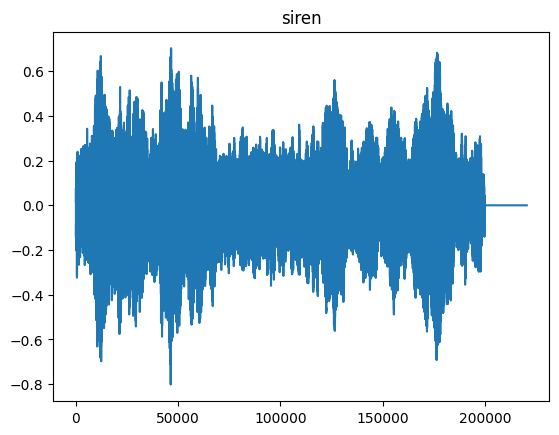

In [ ]:
plt.figure()
plt.title(category)
plt.plot(waveform.t().numpy())

ipd.Audio(waveform.numpy(), rate=sample_rate)

In [ ]:
# create train, val, test subfolders and move data
import os
import shutil

base_dir = './ESC-50-master/audio/'
os.makedirs(os.path.join(base_dir, 'train'))
os.makedirs(os.path.join(base_dir, 'val'))
os.makedirs(os.path.join(base_dir, 'test'))
for file in os.listdir(base_dir):
   train_list = ['1', '2', '3']
   val_list = ['4']
   test_list = ['5']
   if file.endswith('.wav'):
      if file.split("-")[-1].replace(".wav","") in train_list:
         shutil.move(os.path.join(base_dir, file), os.path.join(base_dir, 'train', file))
      elif file.split("-")[-1].replace(".wav","") in val_list:
         shutil.move(os.path.join(base_dir, file), os.path.join(base_dir, 'val', file))
      elif file.split("-")[-1].replace(".wav","") in test_list:
         shutil.move(os.path.join(base_dir, file), os.path.join(base_dir, 'test', file))

In [ ]:
class ESCDataset(Dataset):

  def __init__(self, audio_dir):

    self.features = []
    self.targets = []

    audio_files = []
    for file in os.listdir(audio_dir):
       if file.endswith('.wav'):
          audio_files.append(file)

    for i, file in tqdm(enumerate(audio_files)):

      waveform, sample_rate = torchaudio.load(os.path.join(audio_dir, file))

      # convert to mono if file is in stereo
      if waveform.size()[0] > 1:
        waveform = torch.mean(waveform, dim=0).unsqueeze(0)

      # resample when sample rate too high
      if sample_rate > 22050:
        waveform = torchaudio.transforms.Resample(sample_rate, 22050)(waveform)

      # add padding/length normalization
      # TO DO?

      spectrogram = torchaudio.transforms.Spectrogram()(waveform)
      # re-size and normalize the spectrogram
      spectrogram = F.interpolate(spectrogram.unsqueeze(0), size=(64, 64), mode='bicubic').squeeze(0)
      normalize = torchvision.transforms.Normalize(mean=spectrogram.mean(), std=spectrogram.std())
      spectrogram = normalize(spectrogram)

      self.features.append(spectrogram)
      # targets have to be numpy/tensors
      target = int(file.split("-")[-1].replace(".wav", ""))
      self.targets.append(torch.tensor(target, dtype=torch.long)) # tensor NOT Tensor; use torch.long for classification

  def __len__(self):
    return len(self.features)
  def __getitem__(self, idx):
    return self.features[idx], self.targets[idx]

In [ ]:
train_data_path = "./ESC-50-master/audio/train"
val_data_path = "./ESC-50-master/audio/val"
test_data_path = "./ESC-50-master/audio/test"

train_data = ESCDataset(train_data_path)
val_data = ESCDataset(val_data_path)
test_data = ESCDataset(test_data_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# create data loaders
batch_size=64
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_data_loader  = DataLoader(test_data, batch_size=batch_size)

Text data:

In [ ]:
# see https://github.com/pytorch/text/issues/609 from tokenizer from HF transformers

import torchtext
from torchtext.data import Field, TabularDataset, BucketIterator

# Define the fields for text and label
TEXT = Field(sequential=True, tokenize='spacy', lower=True)
LABEL = Field(sequential=False, is_target=True)

# Load the dataset from Excel file
datafields = [('text', TEXT), ('sentiment', LABEL)]
train_data, test_data = TabularDataset.splits(
    path='', train='reviews.xlsx', test='reviews.xlsx',
    format='xlsx', skip_header=True, fields=datafields
)

# Build the vocabulary
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the fields for text and label
TEXT = Field(sequential=True, tokenize='word', lower=True)
LABEL = Field(sequential=False, is_target=True)

# Load the dataset from Excel file
datafields = [('text', TEXT), ('sentiment', LABEL)]
train_data, test_data = TabularDataset.splits(
    path='', train='reviews.xlsx', test='reviews.xlsx',
    format='xlsx', skip_header=True, fields=datafields
)

# Preprocess text using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
text_data = [example.text for example in train_data]
vectorized_data = vectorizer.fit_transform(text_data)

# Set the vocabulary size
vocab_size = len(vectorizer.get_feature_names())

# Build the vocabulary
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

In [ ]:
# Create data iterators
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), batch_size=batch_size, device=device)

### Define and train the model

In [ ]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Image data:

In [ ]:
# define the network
class SimpleNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(12288, 84) # input layer with the size 64*64*3 (input image)
    self.fc2 = nn.Linear(84, 50)
    self.fc3 = nn.Linear(50,3) # final layer with 3 units as output (for 3 categories)

  def forward(self, x): # bug was here
    x = x.view(-1, 12288) # flatten the input image
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# initialize the model
simplenet = SimpleNet()
simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)

Audio data:

In [ ]:
# define the network
class SimpleNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(4096, 124) # input layer with the size 64*64*1 (input spectrogram)
    self.fc2 = nn.Linear(124, 96)
    self.fc3 = nn.Linear(96,50) # final layer with 50 units as output (for 50 categories)

  def forward(self, x): # bug was here
    x = x.view(-1, 4096) # flatten the input image
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# initialize the model
simplenet = SimpleNet()
simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=4096, out_features=124, bias=True)
  (fc2): Linear(in_features=124, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=50, bias=True)
)

Text data:

In [ ]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        last_hidden = output[-1, :, :]
        logits = self.fc(last_hidden)
        return logits

In [ ]:
# Initialize hyperparameters
vocab_size = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 2
batch_size = 32
epochs = 10

# initialize the LSTM model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

In [ ]:
optimizer = torch.optim.Adam(simplenet.parameters(), lr=0.001)

In [ ]:
# training loop
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
  for epoch in tqdm(range(epochs)):

    training_loss = 0.0 # set for the epoch
    valid_loss = 0.0

    # start training for the given epoch
    model.train()
    correct = 0
    for inputs, labels in train_loader: # during each batch

      inputs = inputs.to(device) # move to GPU
      labels = labels.to(device)

      predictions = model(inputs) # get model predictions for the batch
      loss = loss_fn(predictions, labels) # compare model predictions with target labels

      optimizer.zero_grad() # zero the gradient
      loss.backward() # compute gradient
      optimizer.step() # take an optimization step

      training_loss += loss.item()*inputs.size(0) # accumulating loss over each batch
      _, predicted = predictions.max(1)
      correct += (predicted == labels).sum() # accumulating TP + TN

    # get average training loss for the epoch across all training examples
    # by deviding the accumulated loss by the number of all training examples (20k)
    training_loss /= len(train_loader.dataset) # len(train_loader) gives number of batches
    # calculate training accuracy for all training examples
    train_accuracy = correct / len(train_loader.dataset)

    # evaluate current model performance once all batches were proccessed
    model.eval()
    correct = 0
    for inputs, labels in val_loader:

      inputs = inputs.to(device)
      labels = labels.to(device)

      # Deactivate gradients for making a prediction
      with torch.no_grad(): # (faster and less memory usage)
        predictions = model(inputs)
      loss = loss_fn(predictions, labels)
      valid_loss += loss.item()*inputs.size(0)

      _, predicted = predictions.max(1)
      correct += (predicted == labels).sum()

    # get average validation loss for the epoch across all validation batches
    valid_loss /= len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)

    print(f'Epoch: {epoch+1}, train_loss: {training_loss:.2f},\
          val_loss: {valid_loss:.2f}, val_accuracy = {val_accuracy:.2f},\
          train_accuracy = {train_accuracy:.2f}')

*Start training...*

In [ ]:
train(simplenet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.93,          val_loss: 0.38, val_accuracy = 0.81,          train_accuracy = 0.68
Epoch: 2, train_loss: 0.35,          val_loss: 0.34, val_accuracy = 0.85,          train_accuracy = 0.87
Epoch: 3, train_loss: 0.29,          val_loss: 0.29, val_accuracy = 0.85,          train_accuracy = 0.89
Epoch: 4, train_loss: 0.27,          val_loss: 0.36, val_accuracy = 0.86,          train_accuracy = 0.90
Epoch: 5, train_loss: 0.24,          val_loss: 0.33, val_accuracy = 0.88,          train_accuracy = 0.91
Epoch: 6, train_loss: 0.19,          val_loss: 0.28, val_accuracy = 0.87,          train_accuracy = 0.92
Epoch: 7, train_loss: 0.16,          val_loss: 0.33, val_accuracy = 0.87,          train_accuracy = 0.94
Epoch: 8, train_loss: 0.20,          val_loss: 0.53, val_accuracy = 0.78,          train_accuracy = 0.92
Epoch: 9, train_loss: 0.16,          val_loss: 0.27, val_accuracy = 0.88,          train_accuracy = 0.93
Epoch: 10, train_loss: 0.10,          val_loss: 0.28, v

Image data:

After 20 epochs, we get a validation accuracy of 92 percent and a train accuracy of 99 percent.

In a real world scenario, we also would be interested in the final test accuracy to better understand how well our model generalizes to unseen data.

Audio data:

The model's capacity doesn't seem to be enough to achive any significant improvements.

### Inference and saving model weights

Following is just a small example of how we can perform inference (make predictions) with the trained model:

Image data:

In [ ]:
labels = ['boot','sandal', 'shoe']

img = Image.open("./test/boot/boot (948).jpg")
img = transforms(img).to(device)
img = torch.unsqueeze(img, 0)

# set the model in evaluation mode
simplenet.eval()
prediction = F.softmax(simplenet(img), dim=1)
prediction = prediction.argmax()
print(f'{labels[prediction]}')

boot


In [ ]:
state_dict = simplenet.state_dict()
print(state_dict)
torch.save(state_dict, "shoe_model.tar")

### Test accuracy

In [ ]:
state_dict = torch.load("shoe_model.tar")
simplenet.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            #data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)

            _, predicted = preds.max(1)
            true_preds += (predicted == data_labels).sum()

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Test accuracy of the model: {100.0*acc:4.2f}%")

In [ ]:
eval_model(simplenet, test_data_loader)

Test accuracy of the model: 87.42%


# PyTorch Lightning

https://m.youtube.com/watch?v=Hgg8Xy6IRig

PyTorch Lightning is a wrapper library which allows to re-pack the training loop inside a single module. This doesn't really makes you write less code, but you get out a better structured code.

For a gentle introduction see https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09

Altough, the author suggests to use LightningModule for model and update fuctions, LightningDataModule for DataLoaders, and the Lightning's trainer function to train the model, there are examples where DataLoaders are put inside the LightningModule, which makes it kind of more slick. See an example below in the section on Hugging Face.

Lightning also handles logging and saving model checkpoints automatically with minimal code overhead from our side.

In [1]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.4 MB/s eta 0:00:00


In [2]:
# Setting the seed
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [17]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In PyTorch Lightning, we define `pl.LightningModule`s (inheriting from `torch.nn.Module`) that organize our code into 5 main sections:

- Initialization (__init__), where we create all necessary parameters/models

- Optimizers (configure_optimizers) where we create the optimizers, learning rate scheduler, etc.

- Training loop (training_step) where we only have to define the loss calculation for a single batch (the loop of optimizer.zero_grad(), loss.backward() and optimizer.step(), as well as any logging/saving operation, is done in the background)

- Validation loop (validation_step) where similarly to the training, we only have to define what should happen per step

- Test loop (test_step) which is the same as validation, only on a test set.

In [4]:
class SimpleNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        predictions = self(inputs)
        loss = F.cross_entropy(predictions, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        predictions = self(inputs)
        loss = F.cross_entropy(predictions, labels)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        predictions = self(inputs)
        loss = F.cross_entropy(predictions, labels)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = SimpleNet()

In [18]:
class LightningDataModule(pl.LightningDataModule):
    def __init__(self, train_data_path, val_data_path, test_data_path, batch_size):
        super().__init__()
        self.train_data_path = train_data_path
        self.val_data_path = val_data_path
        self.test_data_path = test_data_path
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_data = ImageFolder(root=self.train_data_path, transform=transforms_img)
        self.val_data = ImageFolder(root=self.val_data_path, transform=transforms_img)
        self.test_data = ImageFolder(root=self.test_data_path, transform=transforms_img)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)

transforms_img = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data_path = "train"
val_data_path = "val"
test_data_path = "test"
batch_size = 64

data_module = LightningDataModule(train_data_path, val_data_path, test_data_path, batch_size)

In [19]:
# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=20, enable_progress_bar=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
# Train the model
trainer.fit(model, data_module)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 1.0 M 
1 | fc2  | Linear | 4.2 K 
2 | fc3  | Linear | 153   
--------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.147     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [22]:
# test the model accuracy
trainer.test(model, data_module, verbose=True)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.7320348620414734     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7320348620414734}]

Besides the `Lightning module`, the second most important module in PyTorch Lightning is the `Trainer`. The trainer is responsible to execute the training steps defined in the Lightning module and completes the framework. Similar to the Lightning module, you can override any key part that you don’t want to be automated, but the default settings are often the best practice to do. The most important functions we use below are:

- `trainer.fit`: Takes as input a lightning module, a training dataset, and an (optional) validation dataset. This function trains the given module on the training dataset with occasional validation (default once per epoch, can be changed)

- `trainer.test`: Takes as input a model and a dataset on which we want to test. It returns the test metric on the dataset.

For training and testing, we don’t have to worry about things like setting the model to eval mode (model.eval()) as this is all done automatically. See below how we define a training function for our models:

# Hugging Face with PyTorch Lightning



Hugging Face transformers is a Python library which allows to use pre-trained large language models and fine-tune them on your own data set using its Trainer API (see https://huggingface.co/course/chapter3/1?fw=pt).

Following this approach, tuning/training a PyTorch model becomes as easy as using Keras' model.fit(). See the following example:

In [ ]:
!pip install pytorch_lightning
!pip install tensorboard
!pip install nlp
!pip install transformers

In [ ]:
import torch
import pytorch_lightning as pl
import nlp
import transformers

In [ ]:
class IMDBSentimentClassifier(pl.LightningModule):

    # initilize the model and model loss
    def __init__(self):
        super().__init__()
        # load a re-trained BERT model from HF transfomers
        self.model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased')
        # cross-entropy loss from PyTorch
        self.loss = torch.nn.CrossEntropyLoss(reduction='none')

    def prepare_data(self):

        # load BERT tokenizer from HF transformers
        tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

        # convert the text field to token ids and add to the data set items
        # text sequences also get normalized here
        def _tokenize(x):
            x['token_ids'] = tokenizer.batch_encode_plus(
                    x['text'],
                    max_length=32,
                    truncation=True,
                    padding=True)
            return x

        # load IMDB data set from HF nlp and split it
        def _prepare_ds(split):
            ds = nlp.load_dataset('imdb', split='train[:10%]')
            ds = ds.map(_tokenize, batched=True)
            ds.set_format(type='torch', columns=['token_ids', 'label'])
            return ds

        self.train_ds, self.test_ds = map(_prepare_ds, ('train', 'test'))

    def forward(self, token_ids):
        mask = (token_ids != 0).float()
        logits, = self.model(token_ids, mask)
        return logits

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch['token_ids'])
        loss = self.loss(logits, batch['label']).mean()
        return {'loss': loss, 'log': {'train_loss': loss}}

    def validation_step(self, batch, batch_idx):
        logits = self.forward(batch['token_ids'])
        loss = self.loss(logits, batch['label'])
        acc = (logits.argmax(-1) == batch['label']).float()
        return {'loss': loss, 'acc': acc}

    def validation_epoch_end(self, outputs):
        loss = torch.cat([o['loss'] for o in outputs], 0).mean()
        acc = torch.cat([o['acc'] for o in outputs], 0).mean()
        out = {'val_loss': loss, 'val_acc': acc}
        return {**out, 'log': out}

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
                self.train_ds,
                batch_size=8,
                drop_last=True,
                shuffle=True,
                )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
                self.test_ds,
                batch_size=8,
                drop_last=False,
                shuffle=True,
                )

    def configure_optimizers(self):
        return torch.optim.SGD(
            self.parameters(),
            lr=1e-2,
            momentum=0.9,
        )

def main(_):
    model = IMDBSentimentClassifier()
    trainer = pl.Trainer(
        default_root_dir='root/logs',
        gpus=(1 if torch.cuda.is_available() else 0),
        max_epochs=10,
        logger=pl.loggers.TensorBoardLogger('root/logs/', name='imdb', version=0),
    )
    trainer.fit(model)


if __name__ == '__main__':
    main(_)

However, in case you need any additional customizations for your training you can still utilize all of the underlying PyTorch functionality and implement your own training loop (see https://huggingface.co/course/chapter3/4?fw=pt).

# Fine Tuning Transformer for MultiClass Text Classification

### Introduction

In this tutorial we will be fine tuning a transformer model for the **Multiclass text classification** problem.
This is one of the most common business problems where a given piece of text/sentence/document needs to be classified into one of the categories out of the given list.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data:
	 - We are using the News aggregator dataset available at by [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)
	 - We are referring only to the first csv file from the data dump: `newsCorpora.csv`
	 - There are `422937` rows of data.  Where each row has the following data-point:
		 - ID Numeric ID
		 - TITLE News title
		 - URL Url
		 - PUBLISHER Publisher name
		 - CATEGORY News category (b = business, t = science and technology, e = entertainment, m = health)
		 - STORY Alphanumeric ID of the cluster that includes news about the same story
		 - HOSTNAME Url hostname
		 - TIMESTAMP Approximate time the news was published, as the number of milliseconds since the epoch 00:00:00 GMT, January 1, 1970


 - Language Model Used:
	 - DistilBERT this is a smaller transformer model as compared to BERT or Roberta. It is created by process of distillation applied to Bert.
	 - [Blog-Post](https://medium.com/huggingface/distilbert-8cf3380435b5)
	 - [Research Paper](https://arxiv.org/abs/1910.01108)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/distilbert.html)


 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup


 - Script Objective:
	 - The objective of this script is to fine tune DistilBERT to be able to classify a news headline into the following categories:
		 - Business
		 - Technology
		 - Health
		 - Entertainment


<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* DistilBERT Model and Tokenizer

Followed by that we will preпare the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU.

In [ ]:
# Importing the libraries needed
import pandas as pd
import torch
!pip install transformers
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.5 MB/s eta 0:00:00


In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes.
*Assuming that the `newCorpora.csv` is already downloaded in your `data` folder*

Import the file in a dataframe and give it the headers as per the documentation.
Cleaning the file to remove the unwanted columns and create an additional column for training.
The final Dataframe will be something like this:

|TITLE|CATEGORY|ENCODED_CAT|
|--|--|--|
|  title_1|Entertainment | 1 |
|  title_2|Entertainment | 1 |
|  title_3|Business| 2 |
|  title_4|Science| 3 |
|  title_5|Science| 3 |
|  title_6|Health| 4 |

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/_NN_NLP/PyTorch/datasets/NewsAggregatorDataset.zip .

In [ ]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
# Import the csv into pandas dataframe and add the headers
df = pd.read_csv('./newsCorpora.csv', sep='\t', names=['ID','TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [ ]:

# # Removing unwanted columns and only leaving title of news and the category which will be the target
df = df[['TITLE','CATEGORY']]
# df.head()

# # Converting the codes to appropriate categories using a dictionary
my_dict = {
    'e':'Entertainment',
    'b':'Business',
    't':'Science',
    'm':'Health'
}

def update_cat(x):
    return my_dict[x]

df['CATEGORY'] = df['CATEGORY'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['CATEGORY'].apply(lambda x: encode_cat(x))
df['ENCODE_CAT'].unique().tolist()

[0, 1, 2, 3]

<a id='section03'></a>
### Preparing the Dataset and Dataloader

We will start with defining few key variables that will be used later during the training/fine tuning stage.

Followed by creation of Dataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing.

Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *Triage* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training.
- We are using the DistilBERT tokenizer to tokenize the data in the `TITLE` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)
- `target` is the encoded category on the news headline.
- The *Triage* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training.

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (422419, 3)
TRAIN Dataset: (337935, 3)
TEST Dataset: (84484, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `DistillBERTClass`.
 - This network will have the DistilBERT Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs.
 - The data will be fed to the DistilBERT Language model as defined in the dataset.
 - Final layer outputs is what will be compared to the `encoded category` to determine the accuracy of models prediction.
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.

#### Loss Function and Optimizer
 - `Loss Function` and `Optimizer` and defined in the next cell.
 - The `Loss Function` is used the calculate the difference in the output created by the model and the actual output.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

#### Further Reading
- You can refer to my [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials) to get an intuition of Loss Function and Optimizer.
- [Pytorch Documentation for Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Pytorch Documentation for Optimizer](https://pytorch.org/docs/stable/optim.html)
- Refer to the links provided on the top of the notebook to read more about DistiBERT.

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process.

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size.
- Subsequent output from the model and the actual category are compared to calculate the loss.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a miniscule loss of 0.0002485 i.e. the output is extremely close to the actual output.

In [ ]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        #breakpoint()
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

This unseen data is the 20% of `newscorpora.csv` which was seperated during the Dataset creation stage.
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

As you can see the model is predicting the correct category of a given headline to a 99.9% accuracy.

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu


In [ ]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Accuracy on test data = 99.99%


<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model.

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

Please remember that a trained neural network is only useful when used in actual inference after its training.

In the lifecycle of an ML projects this is only half the job done. We will leave the inference of these models for some other day.

In [ ]:
# Saving the files for re-use

output_model_file = './models/pytorch_distilbert_news.bin'
output_vocab_file = './models/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


# Hugging Face Pipelines for NLP and ASR

**Installation of the transformers library**

In [ ]:
# development version
!pip install datasets transformers[sentencepiece]
# Datasets is a library for easily accessing and sharing datasets for Audio,
# Computer Vision, and Natural Language Processing (NLP) tasks
# sentencepiece is a unsupervised tokenizer developed by Google for BERT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 15.7 MB/s 
     |████████████████████████████████| 5.5 MB 63.5 MB/s 
     |████████████████████████████████| 115 kB 72.8 MB/s 
     |████████████████████████████████| 95 kB 6.0 MB/s 
     |████████████████████████████████| 163 kB 74.5 MB/s 
     |████████████████████████████████| 212 kB 57.9 MB/s 
     |████████████████████████████████| 127 kB 69.6 MB/s 
     |████████████████████████████████| 115 kB 75.0 MB/s 
     |████████████████████████████████| 7.6 MB 59.4 MB/s 
     |████████████████████████████████| 1.3 MB 50.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


**All magic is behind the pipeline() fuction**

The 🤗 Transformers library provides the functionality to create and use shared models.

The Model Hub (https://huggingface.co/models) contains thousands of pretrained models that anyone can download and use.

The most basic object in the 🤗 Transformers library is the **pipeline() function**. It connects a model with its necessary preprocessing and postprocessing steps, allowing us to directly input any text (*data*) and get an intelligible answer *(model prediction*).

There are three main steps involved when you pass some text to a pipeline:

1. The text is **preprocessed** into a format the model can understand (tokenization, mapping to vocabulary IDs, truncating/padding of string sequence)
2. The preprocessed **inputs are passed to the model** (as embeddings)
3. The **predictions of the model are post-processed**, so you can make sense of them (softmax is applied to logits and mapped to text labels)

A list of pipelines available in transformers can be found here https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline.task
Without any additional parameters, pipeline() selects a default model defined for a specific task. However, we can adjust it. We can find relevant models for a specific task by visiting the Model Hub (https://huggingface.co/models).

When we run pipeline() for the first time, it downloads the required model weights. Then, the weights remain cached in the folder *~/.cache/huggingface/transformers*. You can customize your cache folder by setting the HF_HOME environment variable.

All models can also be served via an Inference API (https://huggingface.co/inference-api) which offers 30k words per months in its free version.

You can also deploy your own instance on AWS SageMaker (https://aws.amazon.com/blogs/machine-learning/host-hugging-face-transformer-models-using-amazon-sagemaker-serverless-inference/).

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier("I've been waiting for a HuggingFace course my whole life.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9598049521446228}]

In [ ]:
# provide sentences as a list to make inference with several sentences
classifier(
    ["I've been waiting for a HuggingFace course my whole life.",
     "I hate this so much!"]
)

In [ ]:
# compare those two if you're thinking that Transformers provide "understanding"
classifier(["I really enjoy to torture others.",
            "I really enjoy to torture others and make them cry."])

[{'label': 'POSITIVE', 'score': 0.5576637387275696},
 {'label': 'NEGATIVE', 'score': 0.5986902713775635}]

For zero-shot classification, for instance, we additionally need to provide a list of candidate labels:

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")
classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'sequence': 'This is a course about the Transformers library',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.8445988297462463, 0.11197440326213837, 0.04342682659626007]}

In [ ]:
classifier(
    "This is a shit show.",
    candidate_labels=["education", "politics", "business"],
)

{'sequence': 'This is a shit show.',
 'labels': ['politics', 'business', 'education'],
 'scores': [0.5890167951583862, 0.315385639667511, 0.09559757262468338]}

In [ ]:
from transformers import pipeline

generator = pipeline("text-generation", model="distilgpt2")
generator("In this course, we will teach you how to")

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 50 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


[{'generated_text': 'In this course, we will teach you how to get and keep your nose up and go with any of the above tips from our instructors and their teachers. There are some simple tips for teaching your nose up and going with any of the above tips,'}]

Or do some Named Entity Recognition (NER):

In [ ]:
from transformers import pipeline

ner = pipeline("ner", aggregation_strategy="simple")
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

With transformers we can also do text summarization:

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization")
summarizer(
    """
    America has changed dramatically during recent years. Not only has the number of
    graduates in traditional engineering disciplines such as mechanical, civil,
    electrical, chemical, and aeronautical engineering declined, but in most of
    the premier American universities engineering curricula now concentrate on
    and encourage largely the study of engineering science. As a result, there
    are declining offerings in engineering subjects dealing with infrastructure,
    the environment, and related issues, and greater concentration on high
    technology subjects, largely supporting increasingly complex scientific
    developments. While the latter is important, it should not be at the expense
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other
    industrial countries in Europe and Asia, continue to encourage and advance
    the teaching of engineering. Both China and India, respectively, graduate
    six and eight times as many traditional engineers as does the United States.
    Other industrial countries at minimum maintain their output, while America
    suffers an increasingly serious decline in the number of engineering graduates
    and a lack of well-educated engineers.
"""
)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

[{'summary_text': ' America has changed dramatically during recent years . The number of engineering graduates in the U.S. has declined in traditional engineering disciplines such as mechanical, civil,    electrical, chemical, and aeronautical engineering . Rapidly developing economies such as China and India continue to encourage and advance the teaching of engineering .'}]

Or translation:

In [ ]:
from transformers import pipeline

translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")
translator("Ce cours est produit par Hugging Face.")

Automatic Speech Recognition:

In [ ]:
from transformers import pipeline

# Load the ASR pipeline
asr_pipeline = pipeline("automatic-speech-recognition")

# Perform ASR on the downloaded audio file
transcription = asr_pipeline('https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/1.flac')
print('==============================')
print(transcription['text'])

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOWER FAT AND SAUCE


There is no built-in pipeline for TTS, yet. See https://huggingface.co/tasks/text-to-speech

In [ ]:
!pip install espnet==202211
!pip install simpleaudio

In [ ]:
!pip uninstall numpy
!pip install numpy

In [ ]:
from espnet2.bin.tts_inference import Text2Speech
import simpleaudio as sa

In [ ]:
text = "Dear Darth Vader, I hereby submit my application to join the esteemed ranks\
of the Stormtroopers. My unwavering loyalty and precision will serve the Galactic Empire\
 with utmost dedication. May the Force be with you. Sincerely, Ivan"

model = Text2Speech.from_pretrained(synthesis_model)
speech  = model(text)['wav']
audio_array = speech.view(-1).cpu().numpy()
play_obj = sa.play_buffer(audio_array, 1, 4, model.fs)
play_obj.wait_done()

If you need to customize your code, you don't have to use pipelines:

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

transcript_text = 'As a young boy on Tatooine, I yearned for a life beyond the barren deserts.\
Raised by my mother, Shmi Skywalker, I possessed an insatiable curiosity about\
the galaxy. Little did I know, my destiny was intertwined with the Force itself.\
After encountering Jedi Master Qui-Gon Jinn and his apprentice, Obi-Wan Kenobi,\
I discovered my Force sensitivity. They believed I was the Chosen One, destined\
to bring balance to the Force. Despite their guidance, I faced many trials and tribulations.\
As a Padawan, I trained under Obi-Wan\'s tutelage. Our bond was strong, but I struggled\
to control my emotions. Fear, anger, and frustration coursed through me. The Jedi Council\'s\
strict adherence to the Jedi Code limited my growth and left me feeling conflicted. The\
death of my mother at the hands of Tusken Raiders ignited a deep-seated anger within me.\
It was a turning point in my life. The Jedi Council\'s inability to prevent her demise\
fueled my disillusionment with their teachings. The seeds of darkness were sown.\
In my quest for power, I was seduced by the dark side of the Force. Under the guidance of\
Darth Sidious, I embraced the Sith ways. The allure of unlimited power and the promise of\
saving those I loved clouded my judgment.\
I became Darth Vader, a Sith Lord feared across the galaxy. Clad in black armor, I wielded\
a crimson lightsaber and led the Emperor\'s merciless Inquisitors. Together, we hunted down\
and eliminated Jedi survivors, extinguishing their light. \
With my connection to the Force forever\
altered, I embraced my new role as his enforcer, carrying out his bidding without question.\
Now, as Darth Vader, I serve the Empire with unwavering loyalty. The galaxy cowers in the face of my might,\
my very presence striking fear into the hearts of rebels and dissenters. The dark side has become my refuge,\
a realm where power reigns supreme.'

summarization_model = 'google/pegasus-xsum'

tokenizer = AutoTokenizer.from_pretrained(summarization_model)
model = AutoModelForSeq2SeqLM.from_pretrained(summarization_model)

prompted_text = ''.join(["summarize: ", transcript_text])
inputs = tokenizer(prompted_text, return_tensors="pt").input_ids
outputs = model.generate(inputs, max_new_tokens=300, do_sample=False)
tokenizer.decode(outputs[0], skip_special_tokens=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.3 MB/s eta 0:00:00


'Star Wars: The Force Awakens opens in cinemas on 25 December 2016.'